In [2]:
%matplotlib widget

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
data_dir = Path.cwd().parents[1] / "_data"

assert data_dir.exists(), data_dir
list(data_dir.glob("*.csv"))

[PosixPath('/Users/jd/Desktop/repos/ama_ws25/_data/siebenkampf.csv'),
 PosixPath('/Users/jd/Desktop/repos/ama_ws25/_data/life_expectancy_data.csv')]

In [4]:
df = (
    pd.read_csv(data_dir / "life_expectancy_data.csv")
    .pipe(
        lambda d: d.set_axis(
            d.columns.str.strip().str.lower()
            .str.replace(" ", "_")
            .str.replace("__+", "_", regex=True),
            axis=1,
        )
    )
    .assign(
        year=lambda d: pd.to_datetime(d.year.astype(str), format="%Y", errors="coerce"),
    )
    .pipe(
        lambda d: d.assign(
            **{
                col: pd.to_numeric(d[col], errors="coerce")
                for col in d.columns
                if col not in {"country", "status", "year"}
            }
        )
    )
)
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015-01-01,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014-01-01,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013-01-01,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012-01-01,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011-01-01,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


## TODO
- filter outliners
- 

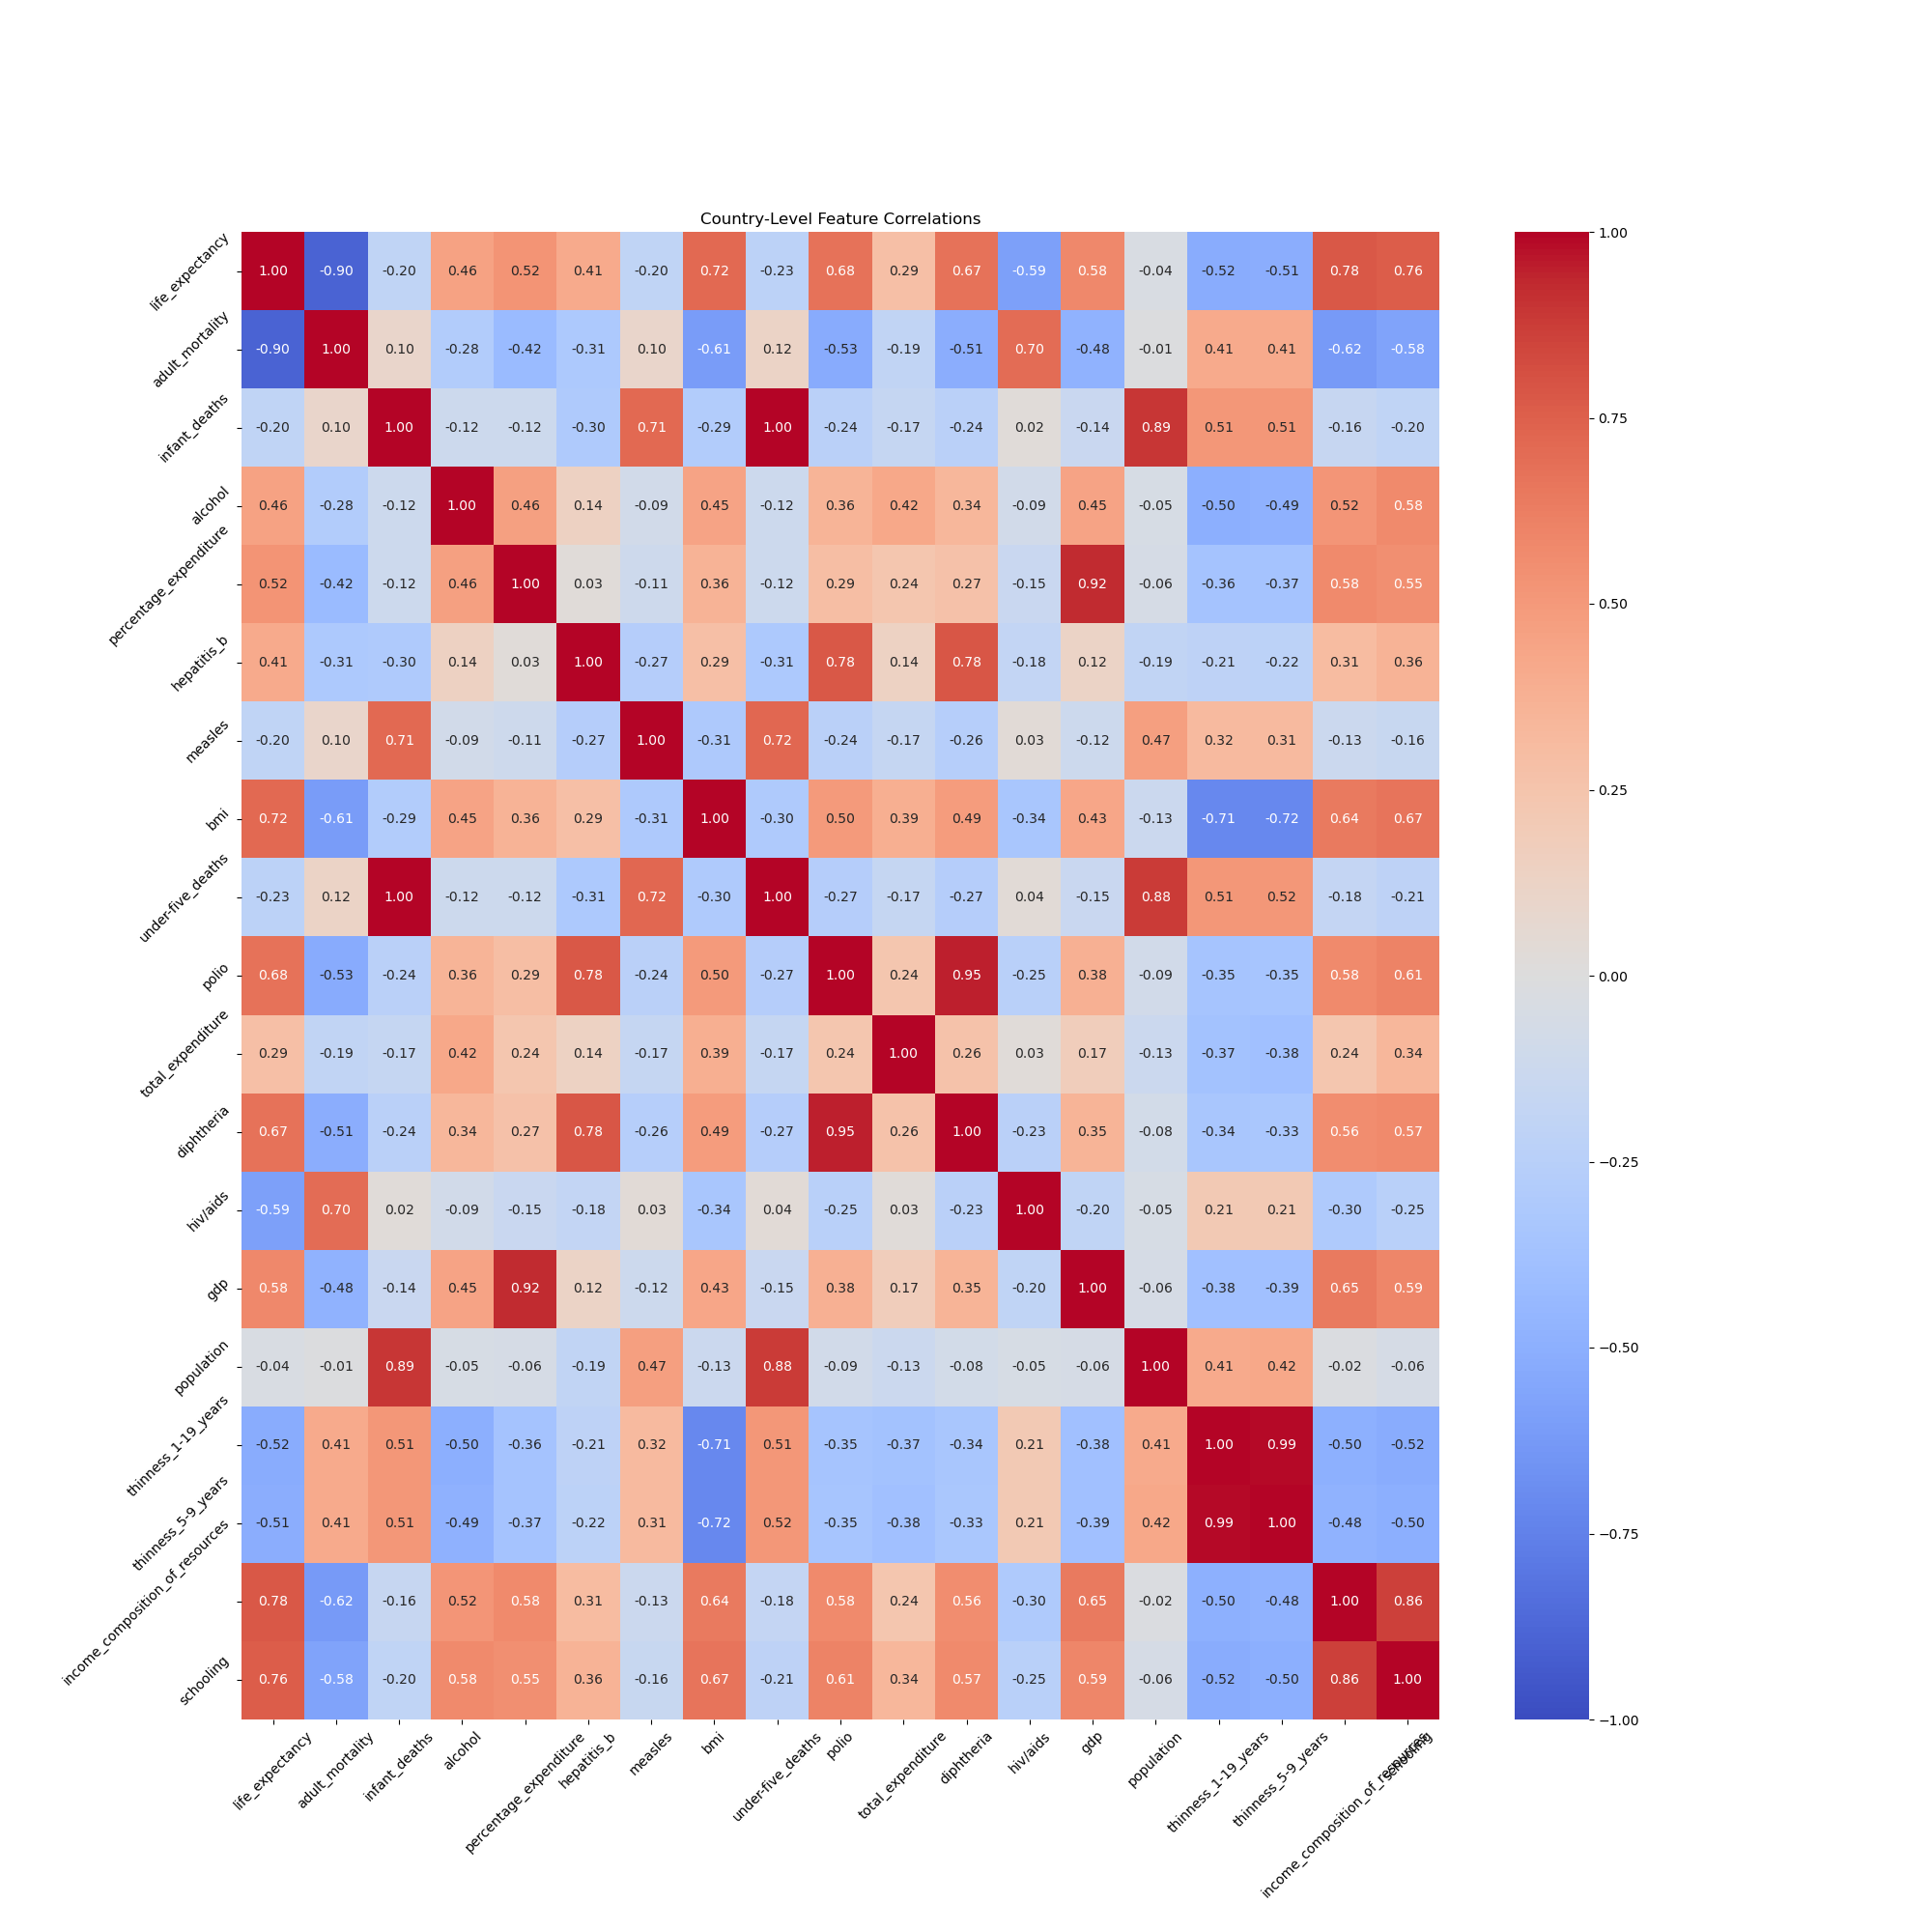

,country,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,58.19375,269.0625,78.2500,0.014375,34.960110,64.562500,2362.2500,15.51875,107.5625,48.3750,8.252500,52.3125,0.10000,340.015425,9.972260e+06,16.58125,15.58125,0.415375,8.21250
1,Albania,75.15625,45.0625,0.6875,4.848750,193.259091,98.000000,53.3750,49.06875,0.9375,98.1250,5.945625,98.0625,0.10000,2119.726679,6.969116e+05,1.61875,1.70000,0.709875,12.13750
2,Algeria,73.61875,108.1875,20.3125,0.406667,236.185241,78.000000,1943.8750,48.74375,23.5000,91.7500,4.604000,91.8750,0.10000,2847.853392,2.164983e+07,6.09375,5.97500,0.694875,12.71250
3,Angola,49.01875,328.5625,83.7500,5.740667,102.100268,70.222222,3561.3125,18.01875,132.6250,46.1250,3.919333,47.6875,2.36875,1975.143045,1.014710e+07,6.19375,6.66875,0.458375,8.04375
4,Antigua and Barbuda,75.05625,127.5000,0.0000,7.949333,1001.585226,98.266667,0.0000,38.42500,0.0000,96.9375,4.791333,98.3125,0.12500,9759.305728,1.274585e+07,3.42500,3.37500,0.488625,8.84375


In [5]:
df = (
    df
    .dropna(subset=["life_expectancy"])
    .groupby("country", as_index=False)
    .mean(numeric_only=True)
    .pipe(
        lambda d: d.assign(
            **{
                col: d[col].fillna(d[col].mean())
                for col in d.columns
                if col != "country"
            }
        )
    )
 )

plt.figure(figsize=(20, 20))
(
    df
    .drop(columns=["country"])
    .corr()
    .pipe(
        lambda d: sns.heatmap(
            d,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
        )
    )
)
plt.tick_params(axis="both", rotation=45)
plt.title("Country-Level Feature Correlations")
plt.show()
df.head()

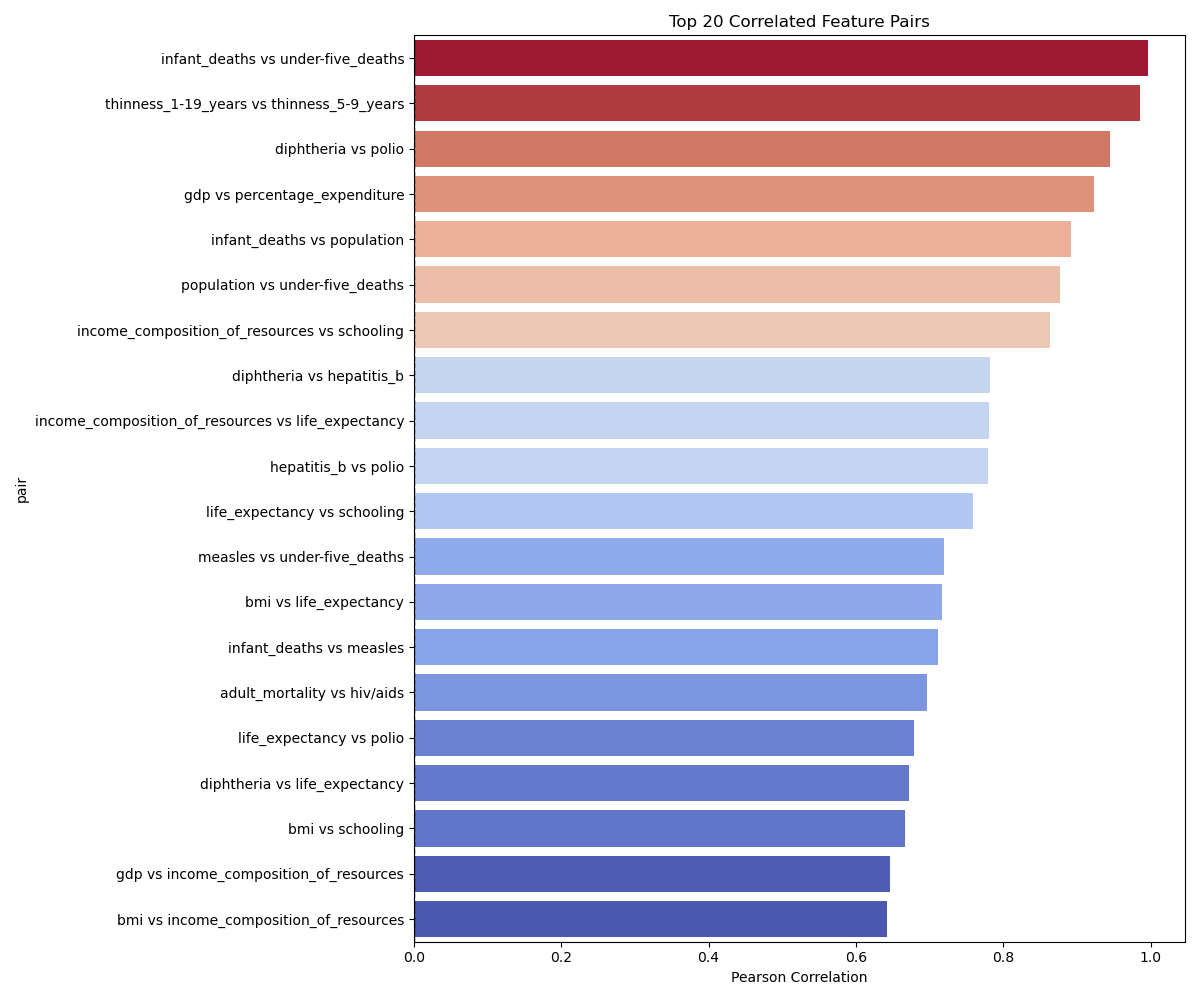

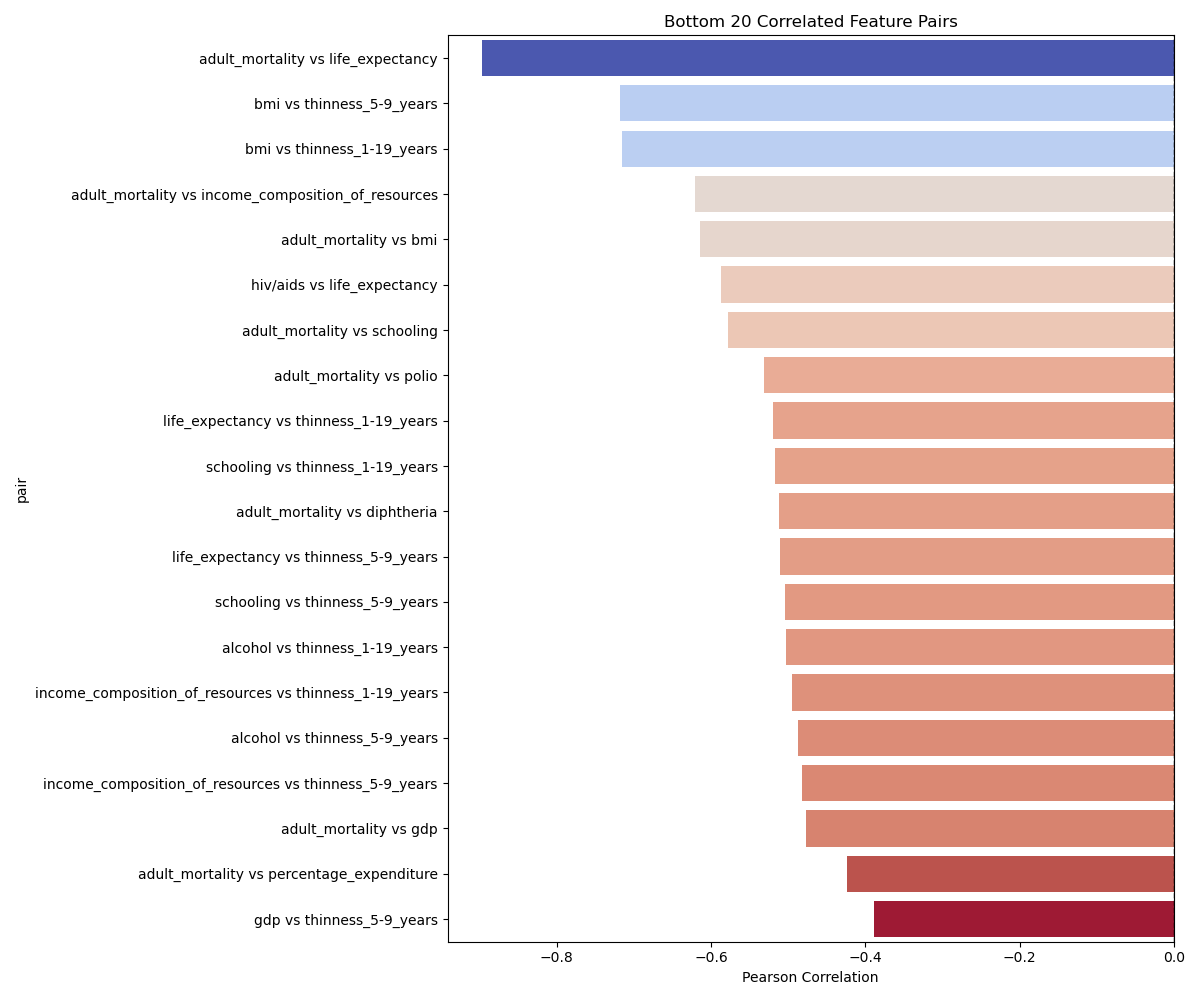

In [6]:
corr_pairs = (
    df
    .drop(columns=["country"])
    .corr()
    .stack()
    .reset_index(name="correlation")
    .query("level_0 < level_1")
    .assign(
        pair=lambda d: d.level_0 + " vs " + d.level_1,
        corr=lambda d: d.correlation,
    )
    .sort_values("correlation", ascending=False)
    .assign(rank=lambda d: d.index + 1)
 )
corr_pairs.head(10)

plt.figure(figsize=(12, 10))
sns.barplot(
    data=corr_pairs.head(20),
    x="correlation",
    y="pair",
    hue="correlation",
    palette="coolwarm",
    legend=False,
 )
plt.title("Top 20 Correlated Feature Pairs")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
sns.barplot(
    data=corr_pairs.tail(20).sort_values("correlation"),
    x="correlation",
    y="pair",
    hue="correlation",
    palette="coolwarm",
    legend=False,
 )
plt.title("Bottom 20 Correlated Feature Pairs")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_93760/680551281.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


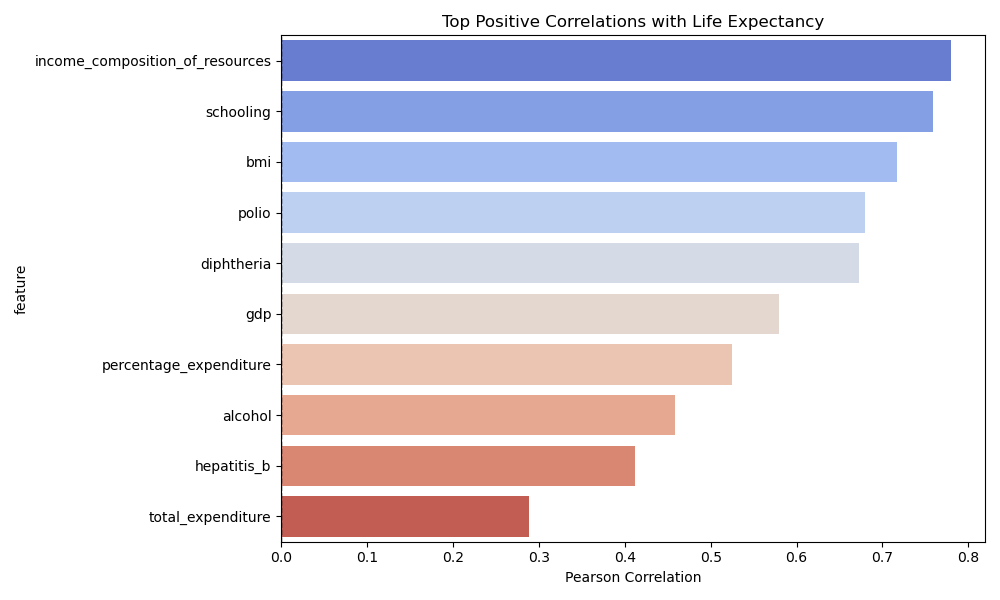

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_93760/680551281.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


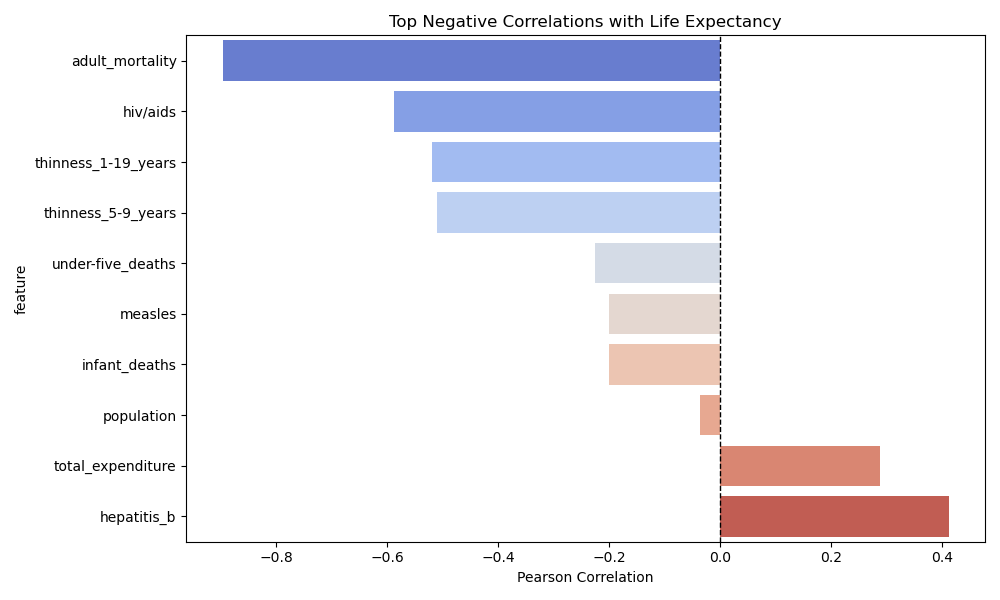

In [7]:
life_corr = (
    df
    .drop(columns=["country"])
    .corr()
    .loc["life_expectancy"]
    .drop("life_expectancy")
    .sort_values(ascending=False)
    .to_frame(name="correlation")
    .assign(feature=lambda d: d.index)
    .reset_index(drop=True)
 )
life_corr.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=life_corr.head(10),
    x="correlation",
    y="feature",
    palette="coolwarm",
)
plt.title("Top Positive Correlations with Life Expectancy")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=life_corr.tail(10).sort_values("correlation"),
    x="correlation",
    y="feature",
    palette="coolwarm",

)
plt.title("Top Negative Correlations with Life Expectancy")
plt.xlabel("Pearson Correlation")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

In [8]:
std_cols = df.drop(columns=["country"]).columns

df_std = (
    df
    .pipe(
        lambda d: pd.concat(
            [
                d[["country"]],
                pd.DataFrame(
                    StandardScaler().fit_transform(d[std_cols]),
                    columns=std_cols,
                    index=d.index,
                ),
            ],
            axis=1,
        )
    )
)
df.head()

,country,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,58.19375,269.0625,78.2500,0.014375,34.960110,64.562500,2362.2500,15.51875,107.5625,48.3750,8.252500,52.3125,0.10000,340.015425,9.972260e+06,16.58125,15.58125,0.415375,8.21250
1,Albania,75.15625,45.0625,0.6875,4.848750,193.259091,98.000000,53.3750,49.06875,0.9375,98.1250,5.945625,98.0625,0.10000,2119.726679,6.969116e+05,1.61875,1.70000,0.709875,12.13750
2,Algeria,73.61875,108.1875,20.3125,0.406667,236.185241,78.000000,1943.8750,48.74375,23.5000,91.7500,4.604000,91.8750,0.10000,2847.853392,2.164983e+07,6.09375,5.97500,0.694875,12.71250
3,Angola,49.01875,328.5625,83.7500,5.740667,102.100268,70.222222,3561.3125,18.01875,132.6250,46.1250,3.919333,47.6875,2.36875,1975.143045,1.014710e+07,6.19375,6.66875,0.458375,8.04375
4,Antigua and Barbuda,75.05625,127.5000,0.0000,7.949333,1001.585226,98.266667,0.0000,38.42500,0.0000,96.9375,4.791333,98.3125,0.12500,9759.305728,1.274585e+07,3.42500,3.37500,0.488625,8.84375


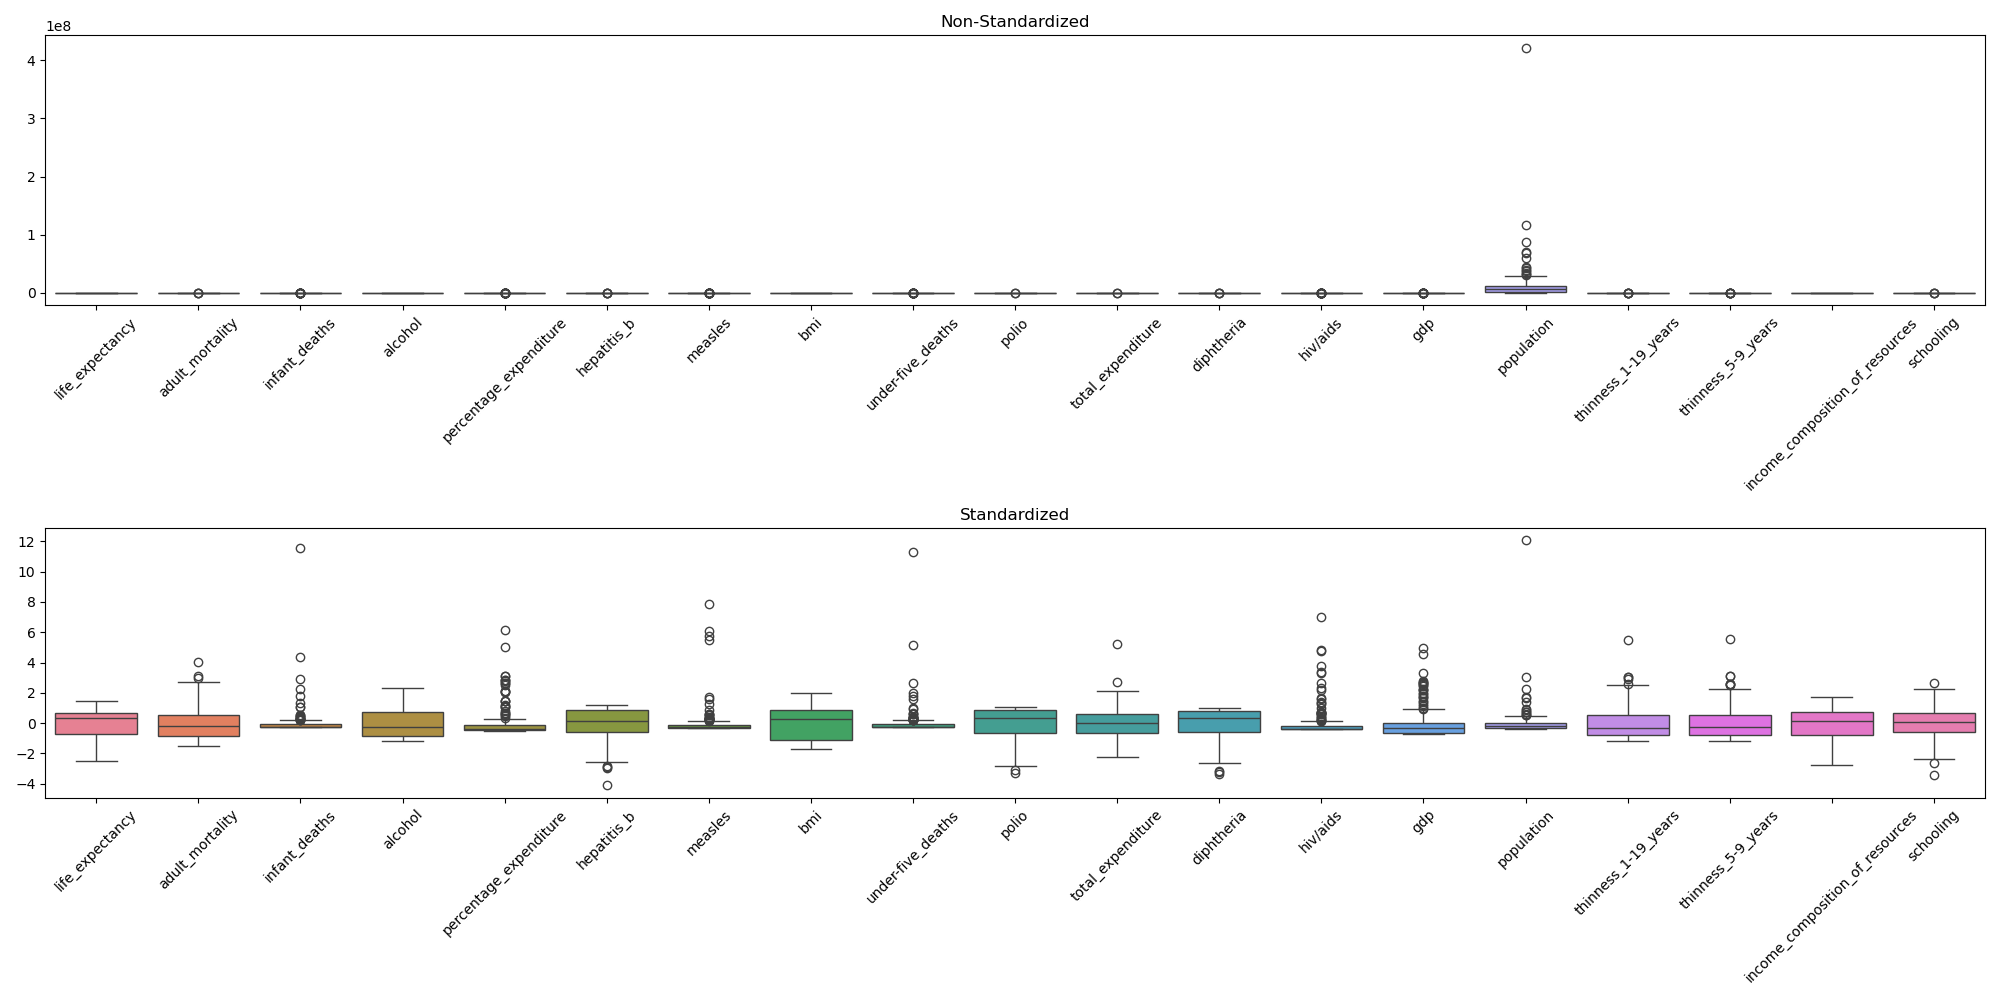

In [9]:
_, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.boxplot(data=df[std_cols], ax=axs[0])
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_title('Non-Standardized')

sns.boxplot(data=df_std[std_cols], ax=axs[1])
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_title('Standardized')

plt.tight_layout()
plt.show()

In [10]:
df_std.describe()

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02,1.830000e+02
mean,-7.231617e-16,8.736181e-17,9.706868e-18,-1.650168e-16,1.456030e-17,1.513665e-16,-3.397404e-17,1.310427e-16,4.853434e-18,4.489426e-17,1.504565e-16,-3.785679e-16,-1.067755e-16,5.824121e-17,-5.824121e-17,-6.309464e-17,9.221525e-17,2.523786e-16,9.221525e-17
std,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00,1.002743e+00
min,-2.522834e+00,-1.522554e+00,-2.628620e-01,-1.202433e+00,-5.012744e-01,-4.109911e+00,-3.012648e-01,-1.714090e+00,-2.686629e-01,-3.295699e+00,-2.237298e+00,-3.360762e+00,-3.714860e-01,-7.242946e-01,-3.767145e-01,-1.169472e+00,-1.152694e+00,-2.783491e+00,-3.451146e+00
25%,-7.367877e-01,-8.797794e-01,-2.628620e-01,-8.787960e-01,-4.793351e-01,-5.790942e-01,-3.002488e-01,-1.099378e+00,-2.674686e-01,-6.769303e-01,-6.408078e-01,-5.951962e-01,-3.714860e-01,-6.318048e-01,-3.317210e-01,-7.617491e-01,-7.594363e-01,-7.803685e-01,-6.077156e-01
50%,3.561251e-01,-1.900914e-01,-2.374683e-01,-2.376179e-01,-3.769155e-01,1.419135e-01,-2.795496e-01,2.817446e-01,-2.451752e-01,3.396298e-01,4.657220e-16,3.532145e-01,-3.714860e-01,-3.452094e-01,-1.951834e-01,-2.924828e-01,-2.622136e-01,1.134567e-01,7.429555e-02
75%,6.419744e-01,5.712694e-01,-7.159892e-02,7.616863e-01,-1.467274e-01,8.678828e-01,-1.118890e-01,8.715042e-01,-7.618325e-02,8.449719e-01,5.964985e-01,8.198326e-01,-1.692804e-01,1.816907e-16,-1.101330e-16,5.614280e-01,5.145085e-01,7.107439e-01,6.501932e-01
max,1.453131e+00,4.016451e+00,1.155169e+01,2.321520e+00,6.135570e+00,1.192885e+00,7.870833e+00,1.976957e+00,1.127613e+01,1.036923e+00,5.217302e+00,1.020896e+00,7.033325e+00,4.991661e+00,1.208329e+01,5.477185e+00,5.559812e+00,1.707041e+00,2.649867e+00


In [11]:
df_std = df_std.set_index("country")

In [12]:
df_std.columns

Index(['life_expectancy', 'adult_mortality', 'infant_deaths', 'alcohol',
       'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi',
       'under-five_deaths', 'polio', 'total_expenditure', 'diphtheria',
       'hiv/aids', 'gdp', 'population', 'thinness_1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

In [13]:
pred_cols = df_std.columns

pca = PCA()
pca_model = pca.fit(df_std[pred_cols])
pca_model

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [14]:
df_std[pred_cols].shape

(183, 19)

In [15]:
pca_model.components_.shape

(19, 19)

In [16]:
pca_model.components_[0]

array([ 0.30817731, -0.2549395 , -0.17530748,  0.21026877,  0.21168064,
        0.18359285, -0.14528917,  0.28440397, -0.18116965,  0.26184328,
        0.14994654,  0.25657353, -0.14116486,  0.23131011, -0.11503299,
       -0.2682166 , -0.267083  ,  0.28416167,  0.29016073])

In [17]:
loadings = (
    pd.DataFrame(
        pca_model.components_,
        columns=pred_cols,
        index=[f"PC{i+1}" for i in range(len(pred_cols))],
    )
    .T.reset_index()
    .rename(columns={"index": "feature"})
)
loadings

,feature,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,life_expectancy,0.308177,0.174511,0.081071,-0.194326,0.011758,0.112522,-0.033834,0.086959,-0.082958,-0.267481,-0.127084,-0.177791,0.029369,0.256604,-0.350741,-0.261225,0.650692,-0.020758,-0.027309
1,adult_mortality,-0.254940,-0.198341,-0.094998,0.391991,0.007273,-0.174250,-0.087732,-0.008198,0.122893,0.379718,0.070975,0.510462,-0.010564,0.138488,-0.260325,-0.131313,0.406072,-0.024479,-0.010523
2,infant_deaths,-0.175307,0.461229,-0.015314,0.064900,-0.138557,-0.021053,-0.037138,-0.139437,0.053113,0.031736,0.006335,-0.037728,-0.016327,-0.368057,0.011479,-0.157973,0.134401,0.034199,0.725452
3,alcohol,0.210269,0.091853,-0.246544,0.296033,-0.150807,-0.002459,0.114501,0.535797,0.633584,-0.186486,0.151052,-0.093822,-0.071556,0.012441,0.017758,0.016420,-0.044920,-0.010866,0.013101
4,percentage_expenditure,0.211681,0.146245,-0.324542,0.095170,0.465921,0.106314,0.186316,-0.262191,0.065742,0.051822,0.019471,-0.016779,0.158515,-0.196940,-0.516292,0.377434,-0.080885,-0.020542,-0.004135
5,hepatitis_b,0.183593,-0.040649,0.513902,0.205039,-0.010846,-0.112825,0.196574,-0.122387,0.099051,0.469814,0.300968,-0.495484,-0.108098,0.058393,-0.085265,0.016555,0.040599,0.031802,0.010834
6,measles,-0.145289,0.340113,-0.081759,0.022592,-0.154880,-0.384625,0.600107,0.149707,-0.376803,-0.094125,0.146963,0.106881,-0.008557,0.309150,-0.071173,0.108208,-0.070927,-0.014655,-0.005187
7,bmi,0.284404,0.036286,-0.080504,-0.102499,-0.279838,-0.039201,-0.367732,-0.204136,-0.116301,-0.163868,0.732035,0.199071,-0.077008,0.026339,-0.096981,0.096922,-0.049442,0.017560,0.002727
8,under-five_deaths,-0.181170,0.453622,-0.030834,0.067645,-0.139875,-0.027925,-0.015327,-0.132741,0.060446,0.043476,0.042759,-0.056494,-0.014913,-0.430365,0.043215,-0.181261,0.124211,0.034367,-0.685818
9,polio,0.261843,0.077277,0.389533,0.219128,0.027414,-0.082906,0.072868,-0.089509,0.044917,-0.223883,-0.121254,0.316436,0.109758,-0.138593,0.375992,0.504414,0.332621,-0.003114,-0.009290


In [30]:
aggregated_loadings = (
    loadings.set_index("feature")
    # .loc[:, ["PC1", "PC2", "PC3"]]
    .abs()
    .sum(axis=1)
    .sort_values(ascending=False)
)
aggregated_loadings

feature
polio                              3.400749
gdp                                3.319246
percentage_expenditure             3.306937
adult_mortality                    3.283534
population                         3.267002
income_composition_of_resources    3.263132
life_expectancy                    3.255172
diphtheria                         3.253391
measles                            3.191700
thinness_5-9_years                 3.105108
hepatitis_b                        3.102678
schooling                          3.030288
bmi                                2.972853
hiv/aids                           2.929551
thinness_1-19_years                2.915073
alcohol                            2.900267
total_expenditure                  2.850789
under-five_deaths                  2.766462
infant_deaths                      2.629734
dtype: float64

In [31]:
top_loading_features = (
    aggregated_loadings
    .index
)

top_loading_features

Index(['polio', 'gdp', 'percentage_expenditure', 'adult_mortality',
       'population', 'income_composition_of_resources', 'life_expectancy',
       'diphtheria', 'measles', 'thinness_5-9_years', 'hepatitis_b',
       'schooling', 'bmi', 'hiv/aids', 'thinness_1-19_years', 'alcohol',
       'total_expenditure', 'under-five_deaths', 'infant_deaths'],
      dtype='object', name='feature')

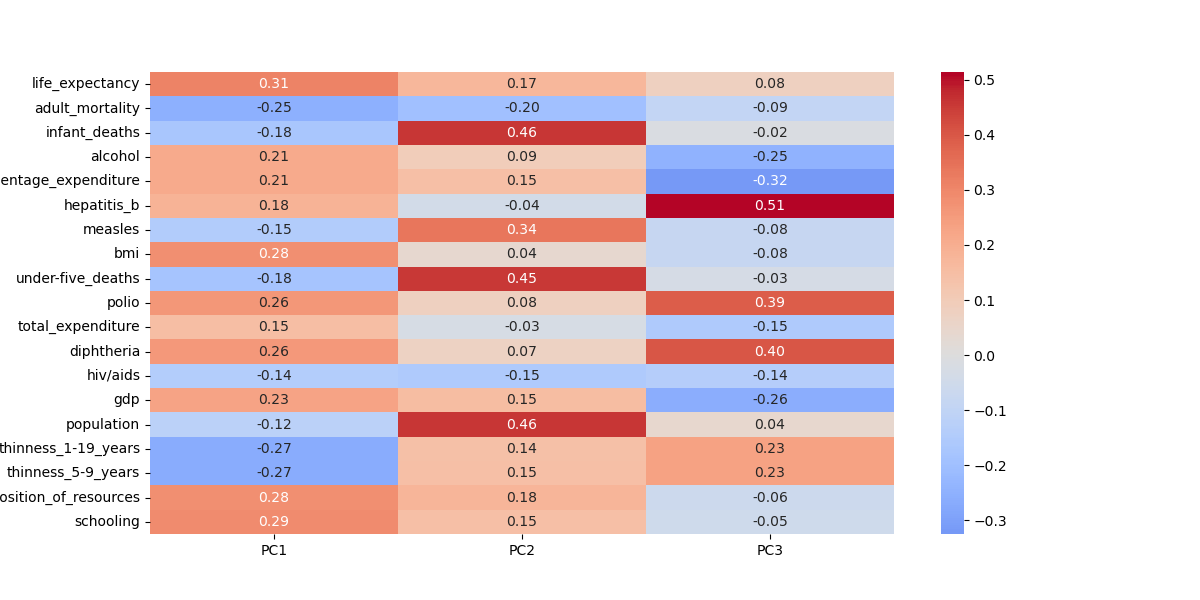

In [45]:
plt.figure(figsize=(12, 6))

sns.heatmap(
    loadings
    .query("feature in @top_loading_features")
    .set_index("feature")
    .loc[:, ["PC1", "PC2", "PC3"]],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
)

plt.show()

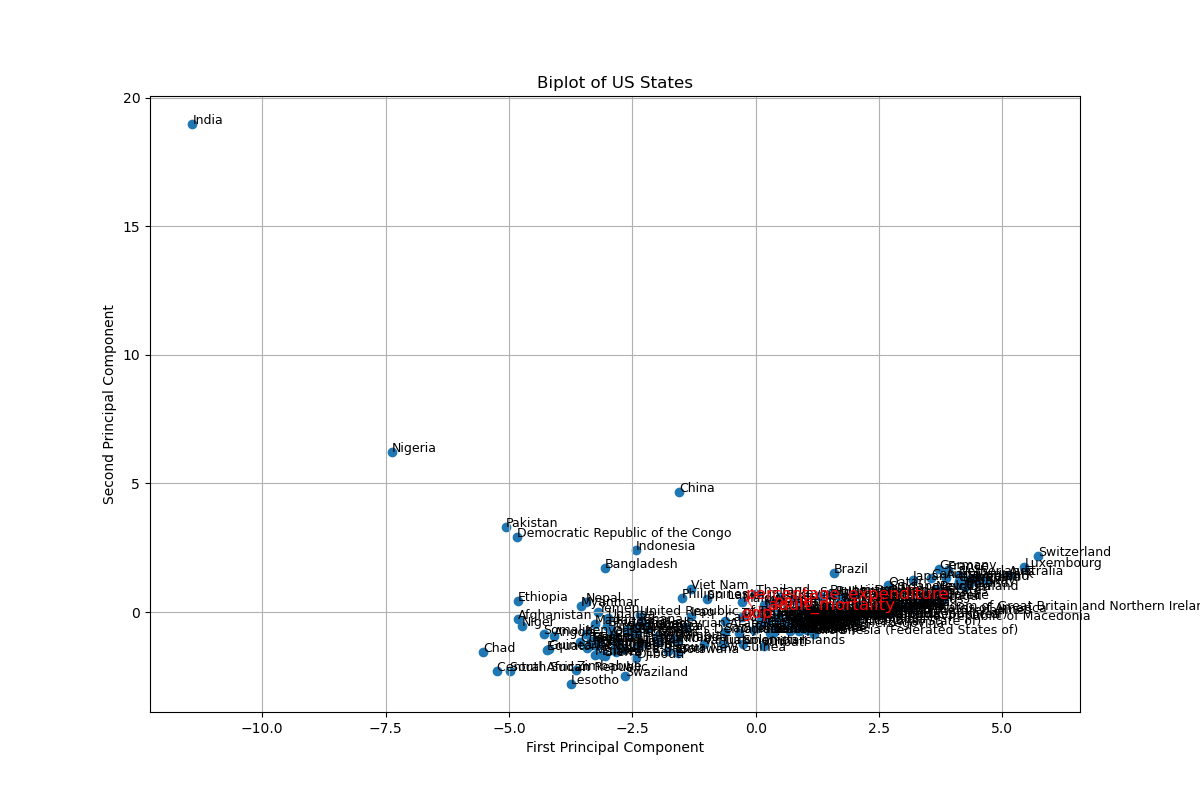

In [ ]:
# Visualize states based on PC1 and PC2
plt.figure(figsize=(12, 8))
pc1 = pca_model.transform(df_std)[:, 0]
pc2 = pca_model.transform(df_std)[:, 1]
plt.scatter(pc1, pc2)

# add labels for each state
for i, state in enumerate(df_std.index):
    plt.text(pc1[i], pc2[i], state, fontsize=9)

# add arrows to illustrate contributions of original variables to the principal components
for i, var in enumerate(top_loading_features[:4]):
    plt.arrow(
        0,
        0,
        pca.components_[0, i],
        pca.components_[1, i],
        color="r",
        alpha=0.5,
        head_width=0.05,
        head_length=0.1,
    )
    plt.text(
        pca.components_[0, i] * 1.15,
        pca.components_[1, i] * 1.15,
        var,
        color="r",
        fontsize=12,
    )

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Biplot of US States")
plt.grid(True)
plt.show()

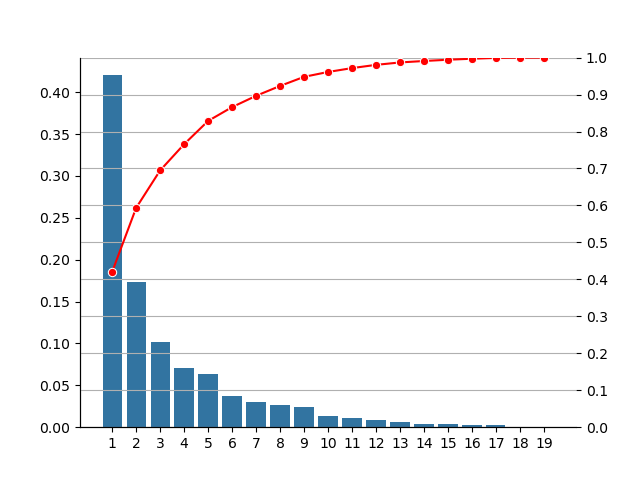

In [59]:
plt.figure()
ax = sns.barplot(
    x=np.arange(1, len(pred_cols) + 1),
    y=pca_model.explained_variance_ratio_,
)
ax = sns.lineplot(
    x=np.arange(0, len(pred_cols)),
    y=pca_model.explained_variance_ratio_.cumsum(),
    marker="o",
    color="red",
    ax=ax.twinx(),
)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
sns.despine(fig=plt.gcf(), top=True)
plt.show()